In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random

The basic form of our problem is that an individual has a preference for a threshold value in the unit-interval, but we can only solicit the direction of the optimum relative to a comparison threshold. In practice, to solicit this direction we compare the values $\lambda \pm \epsilon_0$. However, the closer the more likely our comparison will return the wrong result. 

**Theorem:** Say we have an oracle that given $\lambda \in [0,1]$ points in the direction of $\lambda_0$. The Bayesian update for the location of $\lambda_0$ given a collection of oracle queries is a simple function.

**Proof:** We have,
$$
P(\text{Optimum is at } \lambda_0 | \text{Right Preference at } \lambda) $$ $$ = \cfrac{P(\text{Right Preference at } \lambda | \text{Optimum is at } \lambda_0) \cdot P(\text{Optimum is at } \lambda_0)}{\sum_i P(\text{Preference}_i \text{ at } \lambda | \text{Optimum is at } \lambda_0)} $$ $$
\Rightarrow P_{n+1}(\text{Optimum is at } \lambda_0)= \begin{cases} \cfrac{\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \ \lambda > \lambda_0 \\
\cfrac{1-\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \text{ otherwise} \end{cases}
$$
Since $P_0 = 1$ then $P_1$ is a simple function. Assume for $k = n$ we have that $P_k$ is a simple function. From the above, if $P_k$ is a smple function we see $P_{k+1}$ is a simple function. By induction, $P_n$ for all $n$ is a simple function.

This will guide the creation of our basic data-type for individual preferences since this we now know these will be a simple-function of the queries.

In [370]:
class Simple_Dist:
    
    # param = [(points,values)]
    # constructed left-to-right on [0,1]
    def __init__(self, init, end= 1):
        self.param = init
        self.end = end
        
    def display(self):
        points = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param[:-1]):
            points.append(v)
            points.append((a_param[i+1][0],v[1]))
        x,y = zip(*points)
        plt.plot(x,y)
        plt.title("Median Density")
        plt.ylabel("Density")
        plt.xlabel("Value")
    
    def cdf(self,threshold):
        basis = []
        val = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param):
            if v[0] < threshold:
                basis.append(v[0])
                val.append(v[1])
            else:
                basis.append(threshold)
                cdf = 0
                for i, d in enumerate(val):
                    cdf += d*(basis[i+1]-basis[i])
                return cdf
            
    def invcdf(self, prob):
        a_param = self.param + [(self.end,self.param[-1][1])]
        cdf = 0
        for i, v in enumerate(a_param[:-1]):
            if cdf+v[1]*(a_param[i+1][0]-a_param[i][0])>prob:
                exceed = cdf+v[1]*(a_param[i+1][0]-a_param[i][0])-prob
                return a_param[i+1][0]-exceed/v[1]
            else:
                cdf += v[1]*(a_param[i+1][0]-a_param[i][0])
    
    def median(self):
        return self.invcdf(0.5)
  
    # Vote indicates for direction
    def update_dist(self, threshold, vote, alpha = 0.1, beta = 0.0):
        
        if beta == 0.0:
            beta = 1+alpha
        
        # Insert new data
        index = next(i for i,v in enumerate(self.param+[(1,self.param[-1][1])]) if threshold < v[0])
        if index < len(self.param) and self.param[index][0] != threshold:
            self.param.insert(index,(threshold,self.param[index-1][1]))
        elif index >= len(self.param):
            self.param.insert(index,(threshold,self.param[index-1][1]))
            
        # Modify distribution
        if vote == -1:
            r_mass = 1 - self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] < threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha) / beta)
                else:
                    self.param[i] = (v[0],v[1] * alpha / beta)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
        else:
            l_mass = self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] >= threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)

We can perform some basic sanity checks by setting up setting up a few queries starting with a uniform distribution. Each query indicates a threshold and then is $+1$ if the optimum lays to the right and is $-1$ if the optimum lies to the left. Our $\alpha$ parameter indicates the error rate of the queries. Also note that we are ignoring the $\epsilon_0$ spacing that is needed to ensure $\alpha < 1/2$. 

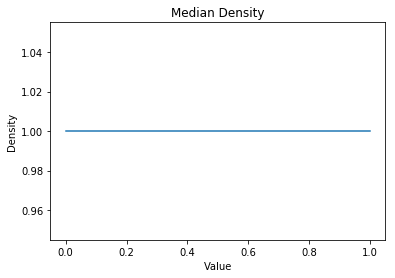

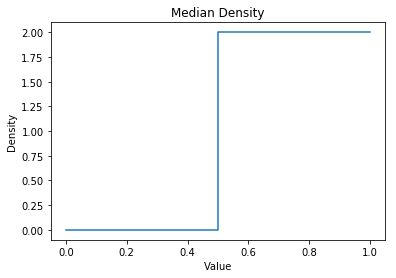

In [28]:
# Basic Demo
alpha = 0.0
dist = Simple_Dist([(0,1)])
dist.display()
plt.show()
dist.update_dist(dist.median(),1, alpha = alpha)
dist.display()
plt.show()

We can randomly sample queries and see how the distribution evolves over time. In expectation, each threshold on the line either gains or loses probability at each round. Using the law of large numbers we can conclude that the threshold that loses the least evidence in each round is the optimum threshold. We can also extract a linear convergence rate. 

0.5431376529819961


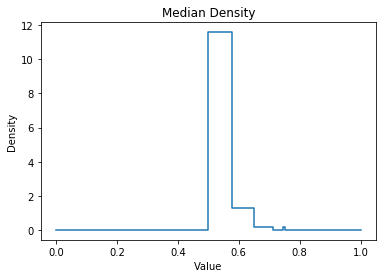

In [29]:
# Oracle at 0.3 with 0.1 error rate
# Random query strategy
dist = Simple_Dist([(0,1)])
dist.update_dist(0.5,1, alpha = alpha)
opt = 0.3
alpha = 0.1
num = 20
query = np.random.rand(num,2)
func = lambda x : x*(1-x)
for i in range(num):
    if query[i][0] < opt:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],-1, alpha = alpha)
    else:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],-1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],1, alpha = alpha)
dist.display()
print(dist.median())

Now we consider performance metric selection for binary classification. Suppose that we have a generative model,
$$\eta(x)  = p(y = 1 | x) = \cfrac{1}{1+e^{5x}}$$
If the performance metric is,
$$\mathcal{L}_{\theta}(h) = \cos(\theta) \text{TP}(h) + \sin(\theta) \text{TN}(h)$$
We can generate a Bayesian optimal classifier according to the rule,
$$h(x) = \mathbb{I} \left(\eta(x) \ge \frac{\cos(\theta)}{\cos(\theta) + \sin(\theta)} \right)$$
The following code introduces useful abstractions for computing quantities of interest such the confusion matrix, loss, and conditional class probability.

In [30]:
def eta(x):
    return 1/(1+np.exp(5*x))

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h = lambda x: hb(x,t)
  if m00 == 0:
    x_prime = 1
  elif m11/m00 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return (1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 1-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 1-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = lambda x: hb(x,t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return (0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t, t_true):
  m11, m00 = np.cos(t_true), np.sin(t_true)
  return m11*C11(t)+m00*C00(t)

def gen_data(size,eta):
    data = []
    labels = [0,1]
    for i in range(size):
        x = 2*np.random.sample(1)[0]-1
        data.append((x,np.random.choice(labels,size = 1, p = [1-eta(x),eta(x)])[0]))
    return data

def hb(x,theta):
    m00, m11 = np.cos(theta), np.sin(theta)
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
    
def classify(theta,x):
  return hb(x,theta)

def f_phi(theta,t,classify,data):
    TP = [0]
    TN = [0]
    for (x,y) in data:
        if y == 0:
            TP.append(1-classify(t,x))
        if y == 1:
            TN.append(classify(t,x))
    return np.mean(TP)*np.cos(theta)+np.mean(TN)*np.sin(theta)

Altering the code to do optimization of a hidden function is quite easy if we drop the assumption that updates will be Bayesian. All we need to do is perform a pair-wise on two points and then put mass pointing in the increasing direction. The reason the algorithm is no longer Bayesian is that there is no predetermined update when the optimum is inbetween the comparison points. For the below implementation we maintain and update 'trisections' defined at the third's of the posterior distribution's cdf. 

In [373]:
def pta(num, alpha, t_phi, prior = None):
    # Oracle at 0.3 with 0.1 error rate
    # Random query strategy
    if prior == None:
        dist = Simple_Dist([(0,1),(0.5,1)])
    else:
        dist = prior
    #dist.update_dist(0.5,1, alpha = alpha)
    query = np.random.rand(num,2)
    run = []
    for i in range(num):
        p1 = dist.invcdf(1/3)
        p2 = dist.invcdf(2/3)
        run.append((p1+p2)/2 * np.pi/2)
        if t_phi(p1*np.pi/2) < t_phi(p2*np.pi/2):
            if query[i][1] > alpha:
                dist.update_dist(p1,1, alpha = alpha)
            else:
                dist.update_dist(p2,-1, alpha = alpha)
        else:
            if query[i][1] > alpha:
                dist.update_dist(p2,-1, alpha = alpha)
            else:
                dist.update_dist(p1,1, alpha = alpha)
    #dist.display()
    return np.array(run), dist.median()*np.pi/2

We also implement a baseline algorithm that uses deterministic bisection strategy based on oracle responses. 

In [374]:
def phi_query(t_1, t_2, alpha, t_phi):
  if t_phi(t_1) < t_phi(t_2):
    if np.random.rand() > alpha:
      return 1  # prefer t2
    else:
      return 0
  else:
    if np.random.rand() > alpha:
      return 0  # prefer t1
    else:
      return 1
    
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def gaurush(iteration, alpha, t_phi):
    query = lambda t_1, t_2, alpha : phi_query(t_1,t_2,alpha,t_phi)
    t_a = 0
    t_b = np.pi/2
    m_bar = np.zeros(2)
    C_bar = 0
    iter = 0
    run = []
    for iter in range(iteration):
        # divide the searching range into equally seperated intervals
        t_c = (3*t_a+t_b)/4
        t_d = (t_a+t_b)/2
        t_e = (t_a+3*t_b)/4
        # compute Confusion Matrices
        C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
        C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
        C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
        C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
        C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
        # pairwise comparisons
        ca = query(t_c, t_a, alpha)
        dc = query(t_d, t_c, alpha)
        ed = query(t_e, t_d, alpha)
        be = query(t_b, t_e, alpha)

        # sanity check for out-of-order responses
        if ca and not dc:
            ca = not ca
        if dc and not ed:
            dc = not dc
        if ed and not be:
            ed = not ed

        # determine the next iter search range based on oracle resposne to query
        if ca:
            t_b = t_d
        elif not ca and dc:
            t_b = t_d
        elif not dc and ed:
            t_a = t_c
            t_b = t_e
        elif not ed and be:
            t_a = t_d
        else:
            t_a = t_d
        
        m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
        C_bar = C_d
        iter += 1
        run = run + [t_d,t_d,t_d,t_d]
        # print("iteration run:"+str(iter))
    return np.array(run) , t_d

As we see below, the PTA works reasonably well. We can run a more exhaustive set of experiments by selecting the true metric randomly and taking the average L2 error over several runs.

Maximizer of True Metric: 0.9837310329422585
Estimator of True Metric: 0.9854777459723059
L2 Norm Error: 2.231933868216871e-08


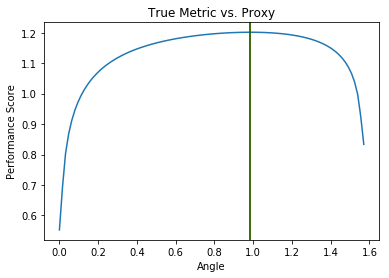

In [35]:
# Pair-wise
# Oracle at 0.3 with 0.1 error rate
# Random query strategy
m_star = (0.98,np.sqrt(1-0.98**2)) #11.47 degree
t_true = random.uniform(np.pi/4,np.pi/2)
data = gen_data(1000,eta)
theta = np.linspace(0,np.pi/2, 100)
y = []
for t in theta:
    y.append(phi(t,t_true))
plt.plot(theta,y)
plt.xlabel("Angle")
plt.ylabel("Performance Score")
plt.title("True Metric vs. Proxy")

_, hat_t = gaurush(iteration = 30, alpha = 0.0, t_phi = lambda t: phi(t,t_true))
plt.axvline(x = hat_t, color = 'r')
plt.axvline(x = t_true, color = 'g')
print("Maximizer of True Metric: " + str(theta[np.argmax(y)]))
print("Estimator of True Metric: " + str(hat_t))
print("L2 Norm Error: " + str(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)])))

Maximizer of True Metric: 1.2217304763960306
Estimator of True Metric: 1.1053731449667046
L2 Norm Error: 0.11785656142755


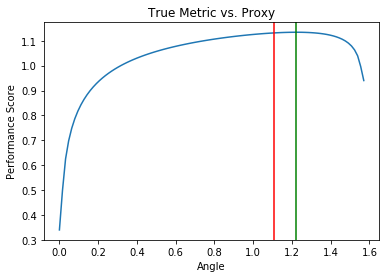

In [36]:
# Pair-wise
# Oracle at 0.3 with 0.1 error rate
# Random query strategy
m_star = (0.98,np.sqrt(1-0.98**2)) #11.47 degree
t_true = random.uniform(np.pi/4,np.pi/2)
data = gen_data(1000,eta)
theta = np.linspace(0,np.pi/2, 100)
y = []
for t in theta:
    y.append(phi(t,t_true))
plt.plot(theta,y)
plt.xlabel("Angle")
plt.ylabel("Performance Score")
plt.title("True Metric vs. Proxy")

_, hat_t = pta(num = 30, alpha = 0.0, t_phi = lambda t: phi(t,t_true))
plt.axvline(x = hat_t, color = 'r')
plt.axvline(x = t_true, color = 'g')
print("Maximizer of True Metric: " + str(theta[np.argmax(y)]))
print("Estimator of True Metric: " + str(hat_t))
print("L2 Norm Error: " + str(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)])))

We can compare the performance of PTA with a baseline algorithm that deterministically bisects the search region. Below we compute the expected performance on randomly selected preferences vs. the noise level. 

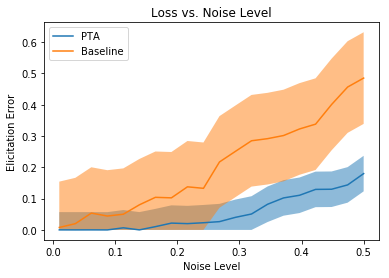

In [402]:
alpha = np.linspace(0.01,0.5,20)
avg_loss_pta = []
avg_loss_g = []
for a in alpha:
    loss_pta = []
    loss_g = []
    for i in range(100):
        t_true = random.uniform(0,np.pi/2)
        _, hat_t = pta(num = 100, alpha = a / (1+a), t_phi = lambda t: phi(t,t_true))
        loss_pta.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)]))
        _, hat_t = gaurush(iteration = 25, alpha = a, t_phi = lambda t: phi(t,t_true))
        loss_g.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)]))
    avg_loss_pta.append(np.mean(loss_pta))
    avg_loss_g.append(np.mean(loss_g))

plt.plot(alpha,avg_loss_pta, label = "PTA")
avg_loss_pta = np.array(avg_loss_pta)
plt.fill_between(alpha,np.maximum(0,avg_loss_pta - np.std(avg_loss_pta)), avg_loss_pta + np.std(avg_loss_pta), alpha = 0.5)

plt.plot(alpha,avg_loss_g, label = "Baseline")
avg_loss_pta = np.array(avg_loss_g)
plt.fill_between(alpha,np.maximum(0,avg_loss_g - np.std(avg_loss_g)), avg_loss_g + np.std(avg_loss_g), alpha = 0.5)
plt.xlabel("Noise Level")
plt.ylabel("Elicitation Error")
plt.title("Loss vs. Noise Level")
plt.legend(loc = "upper left")
plt.savefig("noise_curve.png")

We can also compare the loss vs. the number of comparisons used by both algorithms. 

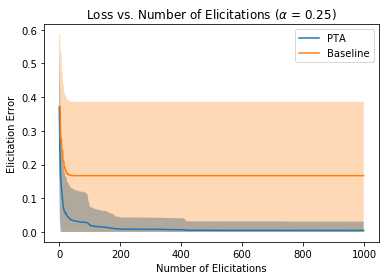

In [400]:
a = 0.25
loss_pta = []
loss_g = []
for i in range(100):
    t_true = random.uniform(0,np.pi/2)
    hat_t, _ = gaurush(iteration = 250, alpha = a, t_phi = lambda t: phi(t,t_true))
    loss_g.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))
    hat_t, _ = pta(num = 1000, alpha = a / (1+a), t_phi = lambda t: phi(t,t_true))
    loss_pta.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))

alpha = range(1000)
plt.plot(alpha,np.mean(loss_pta, axis = 0), label = "PTA")
loss_pta = np.array(loss_pta)
plt.fill_between(alpha,np.maximum(0,np.mean(loss_pta, axis = 0) - np.std(loss_pta, axis = 0)), np.mean(loss_pta, axis = 0) + np.std(loss_pta, axis = 0), alpha = 0.5)

plt.plot(alpha,np.mean(loss_g, axis = 0), label = "Baseline")
loss_g = np.array(loss_g)
plt.fill_between(alpha,np.maximum(0,np.mean(loss_g, axis = 0) - np.std(loss_g, axis = 0)), np.mean(loss_g, axis = 0) + np.std(loss_g, axis = 0), alpha = 0.3)

plt.xlabel("Number of Elicitations")
plt.ylabel("Elicitation Error")
plt.title(r'Loss vs. Number of Elicitations ($\alpha$ = 0.25)')
plt.legend(loc = "upper right")
plt.savefig("loss_curve.png")

It's also possible to do elicitation in the setting where the noise rate is a function of the comparison distance. However, now we must use a power-one statistical test to determine which direction to update in. This can work by summing the oracle returns $S_m$ until we determine with high confidence the direction of the drift. We can take the cut-off point at confidence level $\gamma$ by defining,

$$k_m = (2 m (\log(m+1) - \log(\gamma)))^{1/2}$$

Where $m$ indicates the number of comparisons made up to that point in the test. The first time we have $|S_m| \ge k_m$. For our experiments we pick $\gamma = 0.1$. 

In [394]:
def multi_phi(t1,t2,true_t,alpha):
    S = 0
    for i in range(1,10000):
        s_t = np.random.choice(true_t, size = (1,))
        S += 2 * int(phi(t1,s_t) < phi(t2,s_t))-1
        k = np.sqrt(2*i*(np.log(i+1)-np.log(2*alpha)))
        if S >= k:
            return True, i
        elif S <= -k:
            return False, i
    return S >= 0, 9999

def weight_run(run,weight,num,rep = 1):
    run = np.array(run)
    weight = np.array(weight)
    run = run*np.power(weight,1/2)
    new_run = []
    for i, w in enumerate(list(weight)):
        for j in range(rep*w):
            new_run.append(np.mean(run[:i+1]) / np.mean(np.power(weight[:i+1],1/2)))
            #new_run.append(run[i])
    return new_run[:num]

def g_pta(num, alpha, t_phi, prior = None):
    # Oracle at 0.3 with 0.1 error rate
    # Random query strategy
    if prior == None:
        dist = Simple_Dist([(0,1),(0.5,1)])
    else:
        dist = prior
    #dist.update_dist(0.5,1, alpha = alpha)
    query = np.random.rand(num,2)
    run = []
    weight = []
    s_weight = 0
    while s_weight < num:
        p1 = dist.invcdf(1/3)
        p2 = dist.invcdf(2/3)
        decision, w = t_phi(p1*np.pi/2,p2*np.pi/2)
        s_weight += w
        run.append(dist.invcdf(1/2)*np.pi/2)
        weight.append(w)
        if decision:
            dist.update_dist(p1,1, alpha = alpha)
        else:
            dist.update_dist(p2,-1, alpha = alpha)
    return weight_run(run,weight,num), dist.median()*np.pi/2

def g_gaurush(iteration, alpha, t_phi):
    query = lambda t_1, t_2: t_phi(t_1,t_2)
    t_a = 0
    t_b = np.pi/2
    m_bar = np.zeros(2)
    C_bar = 0
    iter = 0
    run = []
    weight = []
    s_weight = 0
    while s_weight < iteration:
        # divide the searching range into equally seperated intervals
        t_c = (3*t_a+t_b)/4
        t_d = (t_a+t_b)/2
        t_e = (t_a+3*t_b)/4
        # compute Confusion Matrices
        C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
        C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
        C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
        C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
        C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
        # pairwise comparisons
        ca, wa = query(t_c, t_a)
        dc, wc = query(t_d, t_c)
        ed, wd = query(t_e, t_d)
        be, we = query(t_b, t_e)

        # sanity check for out-of-order responses
        if ca and not dc:
            ca = not ca
        if dc and not ed:
            dc = not dc
        if ed and not be:
            ed = not ed

        # determine the next iter search range based on oracle resposne to query
        if ca:
            t_b = t_d
        elif not ca and dc:
            t_b = t_d
        elif not dc and ed:
            t_a = t_c
            t_b = t_e
        elif not ed and be:
            t_a = t_d
        else:
            t_a = t_d
        
        m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
        C_bar = C_d
        iter += 1
        s_weight += wa+wc+wd+we
        for i in range(4*(wa+wc+wd+we)):
            run.append(t_d)
        weight.append(wd)
        # print("iteration run:"+str(iter))
    return  run[:4*iteration], t_d

(0, 0.8099516958019326)
(1, 0.7534053992305807)
(2, 0.9425073784298008)
(3, 0.8268249805318683)
(4, 1.1447198194215826)
(5, 1.1278078026958624)
(6, 1.0036872282100744)
(7, 1.1834714024909854)
(8, 1.0847845455436482)
(9, 1.1583702126694624)
(10, 0.7228985875100763)
(11, 0.4812596158441013)
(12, 0.9207691045074791)
(13, 0.6610822048344309)
(14, 0.6848283652466953)
(15, 0.8811882435621766)
(16, 0.5316249466664362)
(17, 0.9712312787729289)
(18, 0.7440040201096907)
(19, 0.341410573602949)
(20, 0.03773410723149087)
(21, 0.5963516617764189)
(22, 1.269362268010676)
(23, 0.6630878961928911)
(24, 0.9449595202096025)
(25, 1.1139426167766084)
(26, 0.636719373361159)
(27, 0.84451190223365)
(28, 0.8148983133926139)
(29, 0.06378602173759777)
(30, 0.45008325805564686)
(31, 0.7062199797366842)
(32, 0.49710167558318136)
(33, 0.931958144116365)
(34, 0.8079052686573494)
(35, 1.2228672879381761)
(36, 1.0424032828795884)
(37, 1.1255355703807046)
(38, 0.30880587724623193)
(39, 1.0745097642492665)
(40, 0.5843

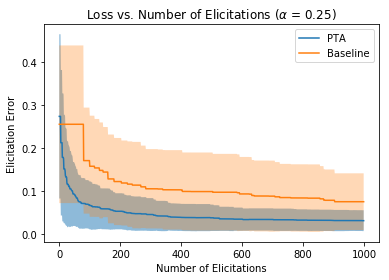

In [398]:
alp = 0.25
loss_pta = []
loss_g = []
for i in range(100):
    a = np.random.uniform(0,np.pi/2, size = 1)[0]
    b = np.random.uniform(0,np.pi/2, size = 1)[0]
    t_true = np.random.uniform(min(a,b),max(a,b), size = 1000)
    print((i,np.median(t_true)))
    hat_t, _ = g_pta(num = 1000, alpha = alp, t_phi = lambda t1,t2: multi_phi(t1,t2,t_true,alp))
    t_true = np.median(t_true)
    loss_pta.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))
    
    a = np.random.uniform(0,np.pi/2, size = 1)[0]
    b = np.random.uniform(0,np.pi/2, size = 1)[0]
    t_true = np.random.uniform(min(a,b),max(a,b), size = 1000)
    hat_t, _ = g_gaurush(iteration = 250, alpha = alp, t_phi = lambda t1,t2: multi_phi(t1,t2,t_true,alp))
    t_true = np.median(t_true)
    loss_g.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))

alpha = range(1000)
plt.plot(alpha,np.mean(loss_pta, axis = 0), label = "PTA")
loss_pta = np.array(loss_pta)
plt.fill_between(alpha,np.maximum(0,np.mean(loss_pta, axis = 0) - np.std(loss_pta, axis = 0)), np.mean(loss_pta, axis = 0) + np.std(loss_pta, axis = 0), alpha = 0.5)

plt.plot(alpha,np.mean(loss_g, axis = 0), label = "Baseline")
loss_g = np.array(loss_g)
plt.fill_between(alpha,np.maximum(0,np.mean(loss_g, axis = 0) - np.std(loss_g, axis = 0)), np.mean(loss_g, axis = 0) + np.std(loss_g, axis = 0), alpha = 0.3)

plt.xlabel("Number of Elicitations")
plt.ylabel("Elicitation Error")
plt.title(r'Loss vs. Number of Elicitations ($\alpha$ = 0.25)')
plt.legend(loc = "upper right")
plt.savefig("loss_curve_multi.png")